**Classifying the Geolocation of Tweets**

In this file, we are going to train 1 baseline (ZeroR) and 4 Machine Learning models (Decision Tree classifier, Naive Bayes, SGD classifier and MLP classifier).
We are going to use the trained model and use it to find the accuracy and F1 score of the development dataset.

If you run the file with the provided dataset attach inside the same folder, this file will run smoothly.

In [1]:
# All the necessary libraries and packages are imported here

import csv
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

Only the raw tweet dataset is imported here. We are going to vectorize and transform in our own conditions.

In [2]:
# Reading and storing all necessary data from files
def csv_reader(filename):
    x = []
    y = []
    with open(filename, "r", encoding="utf8") as files:
        reader = csv.reader(files)
        next(reader, None) # Skipping headers
        for data in reader:
            x.append(data[2])
            y.append(data[0])
            
        y = [] if filename.find("test") != -1 else y
    
    return x, y

x_train_full, y_train_full = csv_reader("data/train_full.csv")
x_dev_full, y_dev_full = csv_reader("data/dev_full.csv")
x_test_full, y_test_full = csv_reader("data/test_full.csv")

len(x_dev_full), len(y_dev_full), len(y_train_full), len(x_train_full), len(x_test_full), len(y_test_full)

(11475, 11475, 133795, 133795, 12018, 0)

In [3]:
# Implementing a 0-R baseline

class_count = Counter(y_train_full)

majority_class = max(class_count, key=lambda k: class_count[k])
y_dev_count_pred = [majority_class] * len(y_train_full)
len(y_dev_count_pred)

baseline_acc = accuracy_score(y_train_full, y_dev_count_pred)
baseline_f1 = f1_score(y_train_full, y_dev_count_pred, average='macro')

print("Baseline Zero-R Metrics")
print("________________________")
print("Accuracy: {}".format(round(baseline_acc, 2)))
print("Macro F1: {}".format(round(baseline_f1, 2)))

Baseline Zero-R Metrics
________________________
Accuracy: 0.39
Macro F1: 0.14


Pie chart of multi class distribution in the dataset

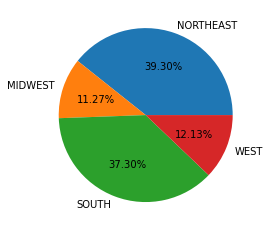

In [4]:
labels = []
label_count = []
for k, v in class_count.items():
    labels.append(k)
    label_count.append(v)
    
plt.pie(label_count, labels=labels, autopct='%1.2f%%')
plt.show()

Tweet tokenisation is done to check if it helps improving the accuracy and F1-score

In [5]:
tt = TweetTokenizer()
stopwords = set(stopwords.words("english"))

In [6]:
def tweet_tokenisation(tweet):
    """
    Function that removes all the stopwords, words that don't have alphabets
    and user tags from a tweet
    """
    processed_tweet = ""
    tokenized_tweet = tt.tokenize(tweet)
    for word in tokenized_tweet:
            word = word.lower()
            if re.search("[a-z]", word) and word not in stopwords and not word.startswith('@'):
                processed_tweet = processed_tweet + " " + word
                
    if not len(processed_tweet):
        processed_tweet = " ".join(tokenized_tweet)
        
    return processed_tweet.strip()


def preprocess_data(tweets, labels):
    x = []
    y = []
    
    # For test data, there are no labels
    if not labels:
        labels = [''] * len(tweets)
        
    for tweet, label in zip(tweets, labels):
        x.append(tweet_tokenisation(tweet))
        y.append(label)

    return x, y

x_train_processed, y_train = preprocess_data(x_train_full, y_train_full)
x_dev_processed, y_dev = preprocess_data(x_dev_full, y_dev_full)
x_test_processed, y_test = preprocess_data(x_test_full, y_test_full)

len(x_train_processed), len(x_dev_processed), len(x_test_processed)

(133795, 11475, 12018)

In [7]:
# Reshaping y values to one hot encode

reshaped_y_train = np.array(y_train).reshape(-1, 1)
reshaped_y_dev = np.array(y_dev).reshape(-1, 1)

enc = OneHotEncoder(sparse=False)
y_enc_train = enc.fit_transform(reshaped_y_train)
y_enc_dev = enc.transform(reshaped_y_dev)

In [8]:
# SGD classifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2')),
               ])

sgd.fit(x_train_full, y_train_full)
sgd_predictions = sgd.predict(x_dev_full)
sgd_acc = accuracy_score(y_dev_full, sgd_predictions)
sgd_f1 = f1_score(y_dev_full, sgd_predictions, average='macro')
        
print("SGD Classifier")
print("Accuracy: {}".format(sgd_acc))
print("F1 score: {}".format(sgd_f1))

SGD Classifier
Accuracy: 0.48026143790849674
F1 score: 0.32243211579111347


In [9]:
# Vectorizing the processed tweet

vec_thread = CountVectorizer()
x_train = vec_thread.fit_transform(x_train_processed)
x_dev = vec_thread.transform(x_dev_processed)
x_test = vec_thread.transform(x_test_processed)

In [10]:
# MLP classifier for processed vectorised tweet

mlp = MLPClassifier(hidden_layer_sizes=3, 
                    activation='relu',
                    solver='adam', 
                    max_iter=5,
                    verbose=True,
                    learning_rate="adaptive"
                   ).fit(x_train, y_train)

# Predicting development data
mlp_prediction = mlp.predict(x_dev)

# Accuracy calculation
mlp_acc = accuracy_score(y_dev, mlp_prediction)

print("MLP classifier")
print("Accuracy: {}".format(mlp_acc))

Iteration 1, loss = 1.26250686
Iteration 2, loss = 1.15512269
Iteration 3, loss = 1.07493660
Iteration 4, loss = 1.00593710
Iteration 5, loss = 0.94611615
MLP classifier
Accuracy: 0.4494989106753813


C:\anaconda\envs\keras_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
# Processed tweets are converted to TF-IDF scores

tfidf_vec = TfidfVectorizer()

x_train_processed_tfidf = tfidf_vec.fit_transform(x_train_processed)
x_dev_processed_tfidf = tfidf_vec.transform(x_dev_processed)
x_test_processed_tfidf = tfidf_vec.transform(x_test_processed)

In [12]:
# Raw tweets are converted to TF-IDF scores

vec = TfidfVectorizer()

x_train_tfidf = vec.fit_transform(x_train_full)
x_dev_tfidf = vec.transform(x_dev_full)
x_test_tfidf = vec.transform(x_test_full)

In [13]:
le = preprocessing.LabelEncoder()
le.fit(['MIDWEST', 'NORTHEAST', 'SOUTH', 'WEST'])
y_train_le = le.transform(y_train)
y_dev_le = le.transform(y_dev)

In [14]:
# DescisionTree Classifier using tfidf scores

dtree = DecisionTreeClassifier().fit(x_train_tfidf, y_train_le)
dtree_predictions = dtree.predict(x_dev_tfidf)
  
# creating a confusion matrix
dtree_acc = accuracy_score(y_dev_le, dtree_predictions)
dtree_cm = confusion_matrix(y_dev_le, dtree_predictions)
print("Decision Tree Classifier")
print("Accuracy {}".format(dtree_acc))

Decision Tree Classifier
Accuracy 0.37132897603485837


In [15]:
# Multinomial Naive Bayes classifier

mnb = MultinomialNB().fit(x_train_tfidf, y_train)
mnb_predictions = mnb.predict(x_dev_tfidf)
mnb_acc = accuracy_score(y_dev, mnb_predictions)
mnb_f1 = f1_score(y_dev, mnb_predictions, average='macro')
mnb_cm = confusion_matrix(y_dev, mnb_predictions)
print("Bayes Classifer")
print("Accuracy: {}".format(mnb_acc))
print("F1 score: {}".format(mnb_f1))

Bayes Classifer
Accuracy: 0.49089324618736385
F1 score: 0.2828538305575369


In [16]:
# Test dataset prediction using Bayes classifier
mnb_test_prediction = mnb.predict(x_test_tfidf)
mnb_test_prediction

array(['SOUTH', 'SOUTH', 'SOUTH', ..., 'NORTHEAST', 'NORTHEAST',
       'NORTHEAST'], dtype='<U9')

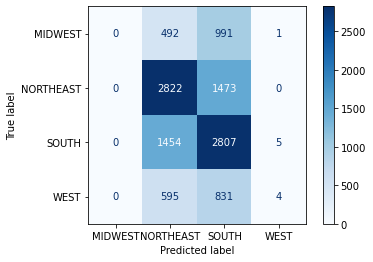

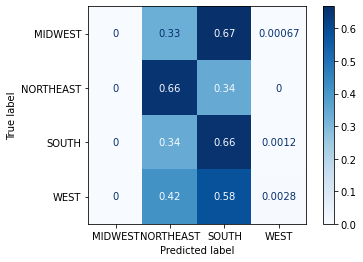

In [17]:
# Confusion matrix of Bayes classifier
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(mnb, x_dev_tfidf, y_dev,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

In [18]:
# CSV file writer
def csv_writer(filename, locations):
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        header = ['id', 'region']
        
        # write the header
        writer.writerow(header)

        # write the data
        for idx, data in enumerate(locations):
            writer.writerow([idx+1, data])
 
csv_writer('mnb_model.csv', mnb_test_prediction)

In [19]:
# Bayes classifier for processed tweet text

clf1 = MultinomialNB().fit(x_train_processed_tfidf, y_train_le)
y_dev_pred = clf1.predict(x_dev_processed_tfidf)
acc_mnb = accuracy_score(y_dev_le, y_dev_pred)
print("Accuracy: {}".format(acc_mnb))

Accuracy: 0.4589106753812636


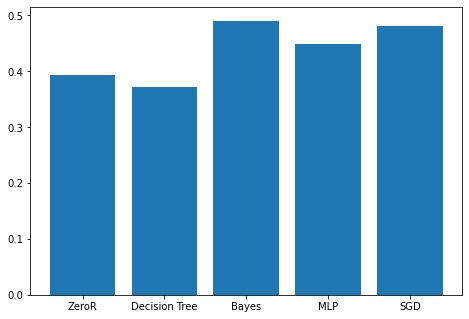

In [20]:
# Bar chart of all the model accuracy scores

accuracy_plt = plt.figure()
axis = accuracy_plt.add_axes([0,0,1,1])
classifiers = ['ZeroR', 'Decision Tree', 'Bayes', 'MLP', 'SGD']
accuracies = [baseline_acc, dtree_acc, mnb_acc, mlp_acc, sgd_acc]
axis.bar(classifiers, accuracies)
plt.show()

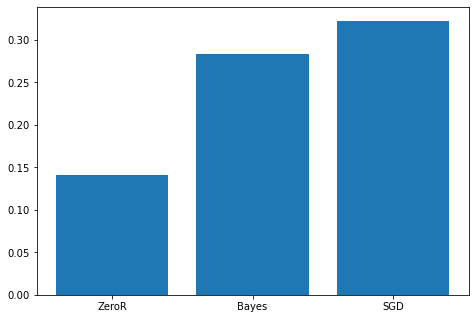

In [21]:
# Bar chart of F1 scores
f1_plt = plt.figure()
axis = f1_plt.add_axes([0,0,1,1])
classifiers = ['ZeroR', 'Bayes', 'SGD']
f1 = [baseline_f1, mnb_f1, sgd_f1]
axis.bar(classifiers, f1)
plt.show()